In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
from hmmlearn import hmm


df = pd.read_csv(here("data/recent_donations.csv"))

,years,num_donations
0,y_2009,0
1,y_2010,0
2,y_2011,0
3,y_2012,0
4,y_2013,0
5,y_2014,0
6,y_2015,0
7,y_2016,0
8,y_2017,0
9,y_2018,0


In [105]:
df["gender"] = df["gender"].map({"M": 0, "F": 1})
year_cols = sorted([col for col in df.columns if col.startswith("y_")]) 
donation_data = df[year_cols].values  # matrice [n_donatori, n_anni]
features = df[["gender", "birth_year", "first_donation_year"]].values  # shape: [n_donatori, 3]

new_df = pd.DataFrame({
    "years": year_cols,
    "num_donations": donation_data[1,:]
})

new_df

,years,num_donations
0,y_2009,2
1,y_2010,1
2,y_2011,2
3,y_2012,2
4,y_2013,1
5,y_2014,1
6,y_2015,3
7,y_2016,3
8,y_2017,3
9,y_2018,4


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scale birth_year and first_donation_year to [0, 1] range
# scaler = MinMaxScaler()
# df[["birth_year", "first_donation_year"]] = scaler.fit_transform(df[["birth_year", "first_donation_year"]])

Let's start with a simple Hidden Markov Model. In this case we assume that the emmissions are continuous and not discrete

In [106]:
sequences = new_df['num_donations'].to_numpy()
X = sequences.reshape(-1, 1)  # Reshape per un singolo esempio

# Costruisci l'HMM (es: GaussianHMM, Poisson non è supportato direttamente)
model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100, random_state=42)
model.fit(X)

Fitting a model with 23 free scalar parameters with only 15 data points will result in a degenerate solution.


GaussianHMM(n_components=4, n_iter=100, random_state=42)


Gaussian distribution means:
[[1.        ]
 [2.        ]
 [3.24999861]
 [2.        ]]

Gaussian distribution covariances:
[[[0.0025    ]]

 [[0.00500001]]

 [[0.18875224]]

 [[0.01000002]]]

Start probabilities:
[0. 1. 0. 0.]

Transition matrix:
[[0.25 0.   0.5  0.25]
 [1.   0.   0.   0.  ]
 [0.14 0.   0.86 0.  ]
 [0.   1.   0.   0.  ]]


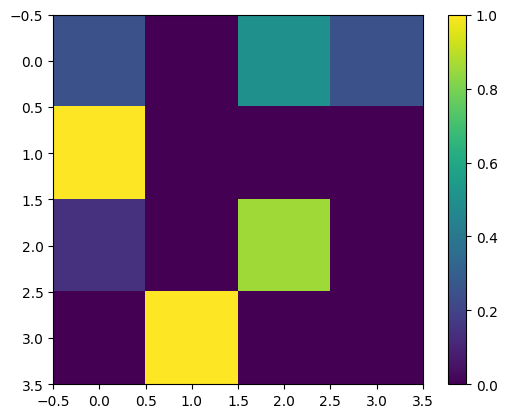

In [107]:
print("\nGaussian distribution means:")
print(model.means_)

print("\nGaussian distribution covariances:")
print(model.covars_)

print("\nStart probabilities:")
print(np.round(model.startprob_, 2))

print("\nTransition matrix:")
print(np.round(model.transmat_,2))

_ = plt.imshow(model.transmat_)
_ = plt.colorbar()

In [108]:
states_sequence = model.predict(X)  # Find most probable hidden states sequence
states_posterior_prob = model.predict_proba(X)  # Find posterior for each hidden state

print("\nMost probable hidden states sequence:")
print(states_sequence)



Most probable hidden states sequence:
[1 0 3 1 0 0 2 2 2 2 0 2 2 2 2]


x: [array(['y_2011'], dtype=object), array(['y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2020', 'y_2021',
       'y_2022', 'y_2023'], dtype=object), array(['y_2009', 'y_2012'], dtype=object), array(['y_2010', 'y_2013', 'y_2014', 'y_2019'], dtype=object)]
y: [array([2], dtype=int64), array([3, 3, 3, 4, 3, 3, 3, 4], dtype=int64), array([2, 2], dtype=int64), array([1, 1, 1, 1], dtype=int64)]


Text(0, 0.5, 'number of donations')

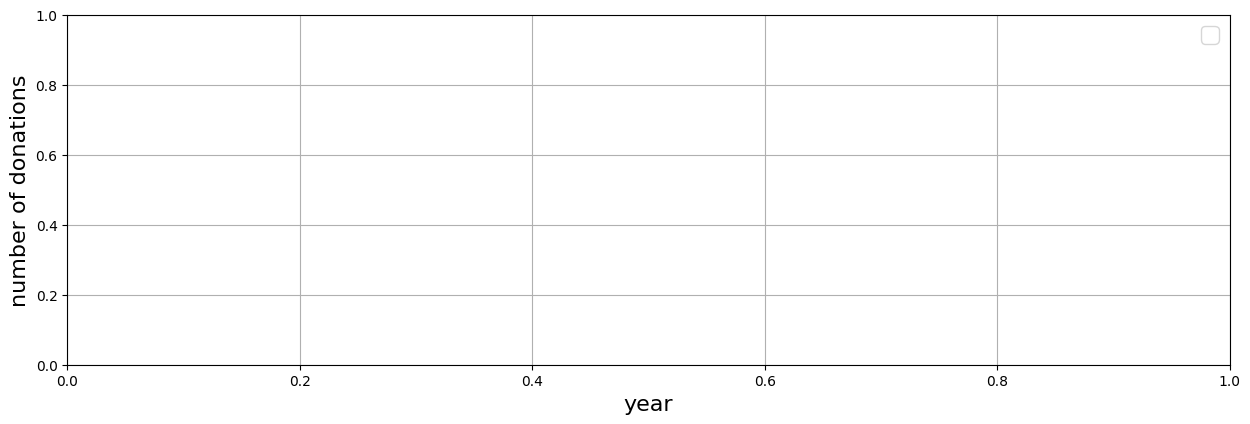

In [118]:
plt.figure(figsize = (15, 10))

STATES = np.unique(states_sequence)[::-1]

plt.subplot(2,1,1)
x = []
y = []
for i in STATES:
    want = (states_sequence == i)

    x_i = new_df['years'][want].values
    y_i = new_df['num_donations'][want].values
    x.append(x_i)
    y.append(y_i)

    # plt.plot(x, y, 'o', alpha = 0.9) # important to use 'o' for discrete data

print("x:", x)
print("y:", y)

plt.legend(STATES, fontsize=16)
plt.grid(True)
plt.xlabel("year", fontsize=16)
plt.ylabel("number of donations", fontsize=16)

# plt.subplot(2,1,2)
# for i in STATES:
#     want = (Z == i)
#     x = data["datetime"].iloc[want]
#     y = data["gold_log_price_change"].iloc[want]
#     plt.plot(x, y, '.', alpha = 0.8)
# plt.legend(STATES, fontsize=16)
# plt.grid(True)
# plt.xlabel("datetime", fontsize=16)
# plt.ylabel("gold log price change (usd)", fontsize=16)
# plt.show()

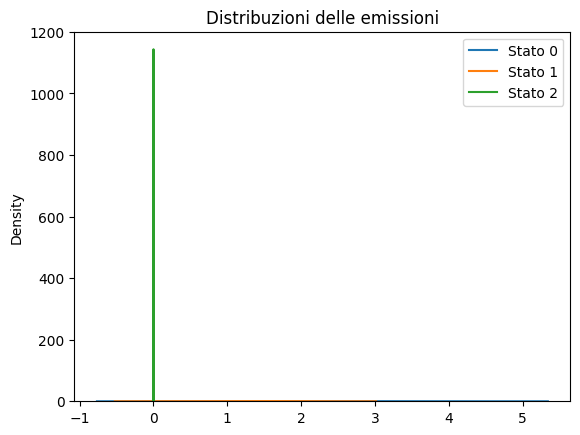

In [60]:
import seaborn as sns

for i in range(model.n_components):
    mu = model.means_[i][0]
    sigma = np.sqrt(model.covars_[i][0])
    sns.kdeplot(np.random.normal(mu, sigma, 1000), label=f"Stato {i}")

plt.title("Distribuzioni delle emissioni")
plt.legend()
plt.show()


## Pyro

In [50]:
# Estrai la matrice y: righe = individui, colonne = anni
donation_cols = [col for col in df.columns if col.startswith("y_")]
Y = df[donation_cols].fillna(0).astype(int).to_numpy()  # [n_donors, T]
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Pyro lavora con torch

In [61]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroParam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
from torch.distributions import constraints
from pyro import poutine

class SimpleDiscreteHMM:
    def __init__(self, num_states=3):
        self.num_states = num_states
        self.lambdas = PyroParam(torch.ones(num_states), constraint=constraints.positive)
        self.start_probs = PyroParam(torch.ones(num_states) / num_states, constraint=constraints.simplex)
        self.trans_probs = PyroParam(torch.ones(num_states, num_states) / num_states, constraint=constraints.simplex)

    @config_enumerate
    def model(self, Y):
        n_donors, T = Y.shape
        num_states = self.num_states

        with pyro.plate("donors", n_donors, dim=-2):
            z_prev = pyro.sample("z_0", dist.Categorical(pyro.param("start_probs")))

            for t in range(T):
                z_t = pyro.sample(f"z_{t}", dist.Categorical(pyro.param("trans_probs")[z_prev]))
                pyro.sample(f"y_{t}", dist.Poisson(self.lambdas[z_t]), obs=Y[:, t])
                z_prev = z_t

from pyro.nn import PyroModule

class Guide(PyroModule):
    def __init__(self, num_states):
        super().__init__()
        self.num_states = num_states

    @config_enumerate
    def forward(self, Y):
        pass  # nessun parametro latente globale da approssimare qui



In [62]:
model = SimpleDiscreteHMM(num_states=3)
guide = Guide(num_states=3)

optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(500):
    loss = svi.step(Y_tensor)
    if step % 50 == 0:
        print(f"Step {step}: loss = {loss:.2f}")



KeyError: 'start_probs'

In [63]:
print("Lambda per stato:", model.lambdas.detach().numpy())
print("Probabilità iniziali:", model.start_probs.detach().numpy())
print("Matrice di transizione:", model.trans_probs.detach().numpy())


AttributeError: 'PyroParam' object has no attribute 'detach'